In [49]:
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten, Add, Conv1D, Layer
from tensorflow.keras.optimizers import RMSprop, Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tensorflow_addons.metrics import F1Score
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from transformers import AutoTokenizer, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from tensorflow.nn import softmax as tf_softmax
import nltk
from nltk.stem import WordNetLemmatizer 
%matplotlib inline

In [50]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive: ', is_interactive())

Interactive:  True


In [51]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [52]:
task = 'b' 
keys_for_task = {'a':'label_sexist','b':'label_category',}
key_for_task = keys_for_task[task]

In [53]:
df = pd.read_csv('C:\\Users\\arnab\\Desktop\\natural language processing project\\train_all_tasks.csv',delimiter=',',encoding='utf-8')
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [54]:
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize(sentence):
    return ' '.join([lemmatizer.lemmatize(word) for word in sentence.split(' ')])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arnab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arnab\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [55]:
df['text'] = df['text'].map(lambda sentence:lemmatize(sentence))
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing wa pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some woman,not sexist,none,none


In [56]:
df.drop(['rewire_id'],axis=1,inplace=True)
df.head(10)

,text,label_sexist,label_category,label_vector
0,"Damn, this writing wa pretty chaotic",not sexist,none,none
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,Understand. Know you're right. At same time I ...,not sexist,none,none
4,Surprized they didn't stop and rape some woman,not sexist,none,none
5,yeah but in order to keep the benefit i have t...,not sexist,none,none
6,Hahaha I just wish they would live their truth...,not sexist,none,none
7,head mod said she talked to him after he made ...,not sexist,none,none
8,"just the inside of your wallet: cash, bank car...",sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...
9,We most definitely did. I didn’t go too much i...,not sexist,none,none


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            14000 non-null  object
 1   label_sexist    14000 non-null  object
 2   label_category  14000 non-null  object
 3   label_vector    14000 non-null  object
dtypes: object(4)
memory usage: 437.6+ KB
None


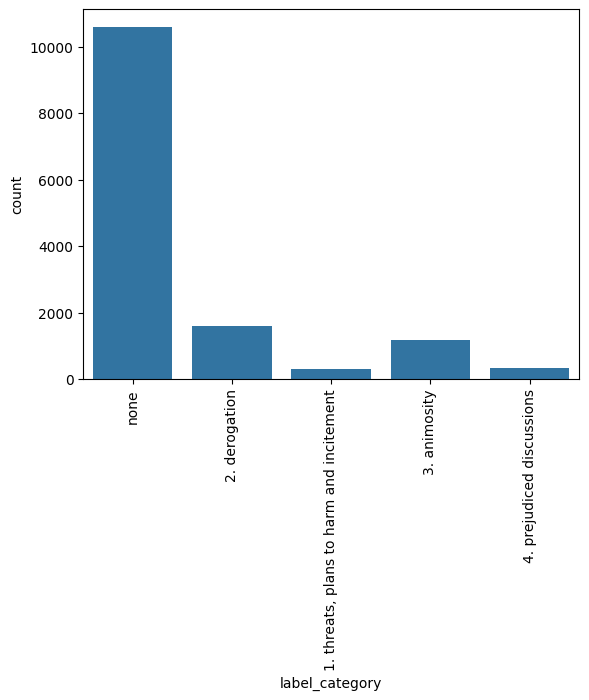

In [57]:
def count_plot(df, name, key_count = key_for_task):
    print(df.info())
    sn.countplot(data=df, x=key_count)
    plt.xticks(rotation = 90)
    plt.savefig(name)
    plt.show()
    
count_plot(df,"distribution.svg")

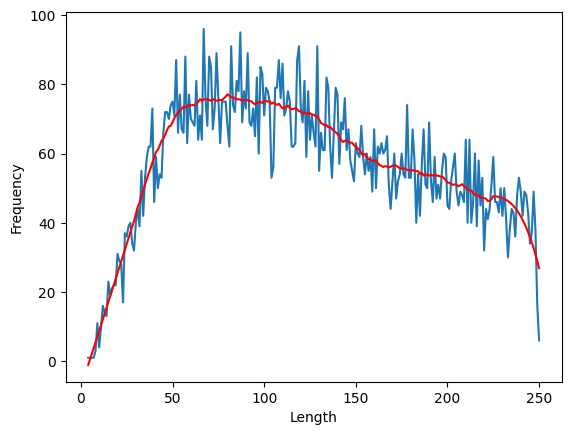

In [58]:
lens = df.text.str.len().value_counts()
count_plot = pd.DataFrame({'leng':lens.index, 'freq':lens.values}).sort_values('leng')
plt.plot(count_plot.leng,count_plot.freq)
plt.plot(count_plot.leng,savgol_filter(count_plot.freq, 51, 3), color='red')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [59]:
label_encoder = LabelEncoder()

# label encoding

X = df['text']
Y = df[key_for_task]
Y = label_encoder.fit_transform(Y)

In [60]:
label_encoder_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_encoder_mapping)
inverse_label_encoder_mapping = {label_encoder_mapping[k]:k for k in label_encoder_mapping}
print(inverse_label_encoder_mapping)

NUM_CLASS = len(label_encoder_mapping)

{'1. threats, plans to harm and incitement': 0, '2. derogation': 1, '3. animosity': 2, '4. prejudiced discussions': 3, 'none': 4}
{0: '1. threats, plans to harm and incitement', 1: '2. derogation', 2: '3. animosity', 3: '4. prejudiced discussions', 4: 'none'}


In [61]:
Y = tf.keras.utils.to_categorical(Y, num_classes=NUM_CLASS)

In [62]:
DEBUG_EPOCH = 20 

EPOCH = DEBUG_EPOCH
print(EPOCH)

LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2

20


In [63]:
class Sentence2Sentence(Layer):
    def __init__(self, **kwargs):
        super(Sentence2Sentence, self).__init__(**kwargs)

        pre_name = "sentence-transformers/all-MiniLM-L6-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(pre_name)
        self.model = TFAutoModel.from_pretrained(pre_name)

        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode('utf-8') for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return (outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask'])

        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])

    def process(self,i,t,a):

        def __call(i, t, a):
            model_output = self.model({'input_ids': i.numpy(),'token_type_ids': t.numpy(),'attention_mask': a.numpy()})
            return model_output[0]

        return tf.py_function(func=__call, inp=[i, t, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1),tf.shape(token_embeddings)), tf.float32)
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        (embeddings, _) = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        (input_ids, token_type_ids, attention_mask) = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        token_type_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids, token_type_ids,attention_mask)
        
        model_output[0].set_shape(tf.TensorShape((None, None, 384)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        # Reshape embeddings to have a third dimension
        embeddings = tf.expand_dims(embeddings, axis=-1)
        return embeddings

In [64]:
class StringLowerLayer(Layer):
    def __init__(self, **kwargs):
        super(StringLowerLayer, self).__init__(**kwargs)
        
    def call(self, inputs):
        return tf.strings.lower(inputs)

In [65]:
class StressLayer(Layer):
    def __init__(self, **kwargs):
        super(StressLayer, self).__init__(**kwargs)

In [66]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def get_model():
    # Input layer
    input_layer = Input(shape=(1,), dtype=tf.string,)
    sentence_layer = Sentence2Sentence()(input_layer)
    
    # Convolutional layers
    conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(sentence_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    conv3 = Conv1D(filters=32, kernel_size=2, activation='relu')(pool2)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    # Flatten layer
    flatten_layer = Flatten()(pool3)

    # Dense layers
    dense1 = Dense(128, activation='relu')(flatten_layer)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    output_layer = Dense(NUM_CLASS, activation='softmax')(dropout2)

    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy',
            F1Score(num_classes=NUM_CLASS,average='weighted'),
        ],
    )
    
    return model

In [67]:
model = get_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [68]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 sentence2_sentence_2 (Sent  (None, 384, 1)            22713216  
 ence2Sentence)                                                  
                                                                 
 conv1d_6 (Conv1D)           (None, 380, 128)          768       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 190, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 188, 64)           24640     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 94, 64)            0   

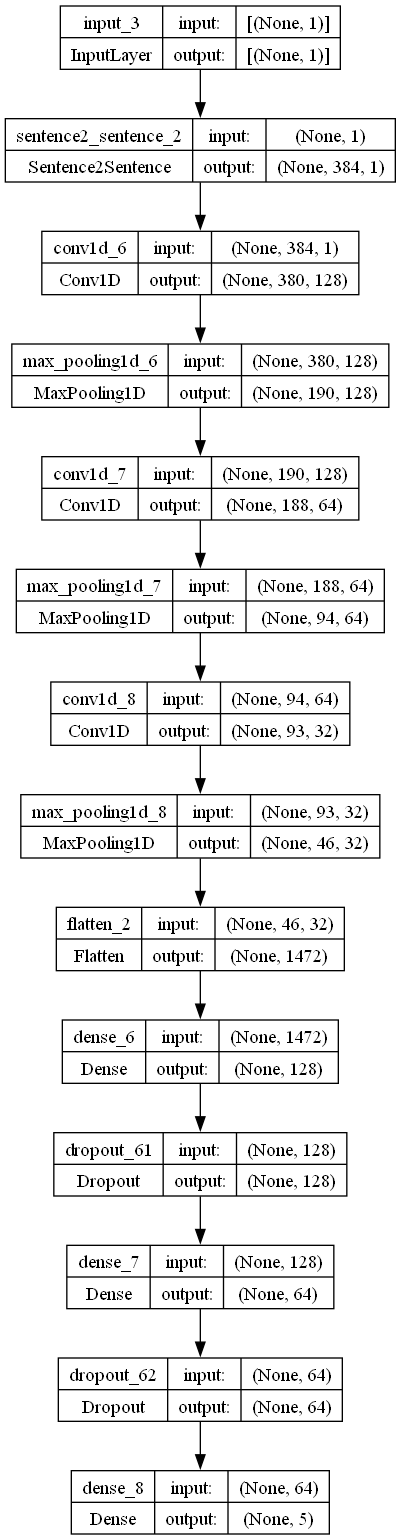

In [69]:
tf.keras.utils.plot_model(model, to_file='model.png',expand_nested=True,show_shapes=True,dpi=None,)

In [70]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10)
early_stopping_callback = EarlyStopping(monitor='val_loss',min_delta=0,patience=30,verbose=0, mode='auto')
model_saver = ModelCheckpoint(filepath='model.h5', save_best_only=True)

callbacks = [early_stopping_callback, lr_reducer,model_saver]

In [71]:
SHUFFLE_DS = 1024
BATCH_SIZE_DS = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

if task == 'a':
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3, stratify=Y)
else:
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3)


# train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).repeat().shuffle(SHUFFLE_DS).batch(BATCH_SIZE_DS).prefetch(AUTO)
# val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_Y)).repeat().shuffle(SHUFFLE_DS).batch(BATCH_SIZE_DS).prefetch(AUTO)
    
N_STEPS = len(train_X) / BATCH_SIZE_DS

In [72]:
history_model = model.fit(train_X, train_Y,epochs=EPOCH,validation_data=(val_X, val_Y), callbacks=callbacks, steps_per_epoch = N_STEPS)

Epoch 1/20
613/612 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.6488 - f1_score: 0.6146

c:\Users\arnab\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


612/612 [==============================] - 180s 292ms/step - loss: 0.4165 - accuracy: 0.6488 - f1_score: 0.6146 - val_loss: 0.2846 - val_accuracy: 0.7586 - val_f1_score: 0.6544 - lr: 5.0000e-05
Epoch 2/20
612/612 [==============================] - 172s 281ms/step - loss: 0.3400 - accuracy: 0.7435 - f1_score: 0.6496 - val_loss: 0.2864 - val_accuracy: 0.7586 - val_f1_score: 0.6544 - lr: 5.0000e-05
Epoch 3/20
612/612 [==============================] - 182s 297ms/step - loss: 0.3281 - accuracy: 0.7499 - f1_score: 0.6508 - val_loss: 0.2823 - val_accuracy: 0.7586 - val_f1_score: 0.6544 - lr: 5.0000e-05
Epoch 4/20
612/612 [==============================] - 232s 380ms/step - loss: 0.3243 - accuracy: 0.7544 - f1_score: 0.6518 - val_loss: 0.2831 - val_accuracy: 0.7586 - val_f1_score: 0.6544 - lr: 5.0000e-05
Epoch 5/20
612/612 [==============================] - 304s 496ms/step - loss: 0.3175 - accuracy: 0.7562 - f1_score: 0.6523 - val_loss: 0.2828 - val_accuracy: 0.7586 - val_f1_score: 0.6544 - l

In [73]:
!mkdir history

A subdirectory or file history already exists.


In [74]:
with open('C:\\Users\\arnab\\Desktop\\natural language processing project\\history.json','w') as f:
    f.write(str(history_model.history))

In [75]:
!mkdir figures

A subdirectory or file figures already exists.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


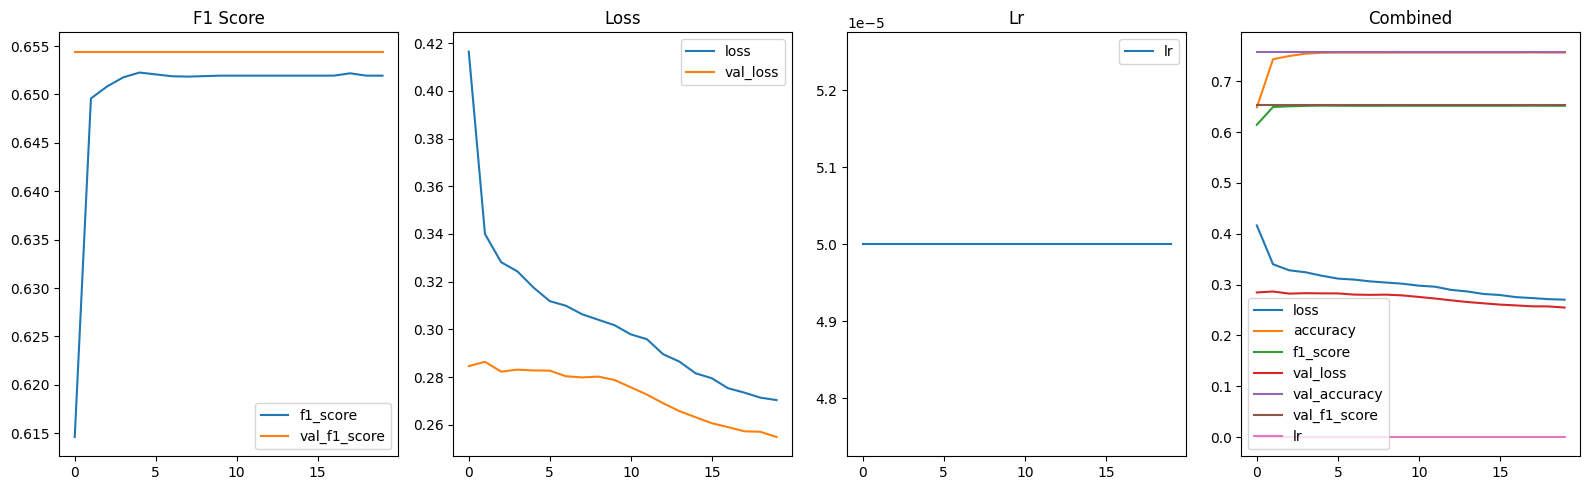

In [77]:
def captilize(string):
    string = string.replace("_"," ")
    return string.title()
    
    
def plot_graphs(data, keys):
    fig, axes = plt.subplots(1, (len(keys) + 1) , figsize=(16, 5))
    plt.legend(loc='best')
    
    for i in range(len(keys)):
        df_graph = pd.DataFrame({x:data[x] for x in data if keys[i] in x})
        df_keys = [x for x in data if keys[i] in x]
        df_graph[df_keys].plot(ax=axes[i])
        axes[i].set_title(captilize(keys[i]))
        
    last_index = len(keys)
    all_keys = [x for x in data if x]
    
    df_combined = pd.DataFrame({x: data[x] for x in data})
    df_combined[all_keys].plot(ax=axes[last_index])
    axes[len(keys)].set_title('Combined')
    
    plt.tight_layout()
    
    plt.savefig('figures/figure_optimizer.svg')
    plt.show()
        
plot_graphs(data = history_model.history, keys= ['f1_score','loss', 'lr'])